In [1]:
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import seaborn as sns
from tqdm import trange
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torchvision.datasets.mnist import MNIST, FashionMNIST

import diffusers
from dataclasses import dataclass
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL

@dataclass
class TrainingConfig:
    image_size=32 #Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    seed = 0
    
config = TrainingConfig()

data_dir = "./data"


print("pyTorch Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Count:", torch.cuda.device_count())
    print("CUDA Current Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
        

    print("pyTorch Version: ", torch.__version__)
    print("pyTorch CUDA Version: ", torch.version.cuda)
#torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

pyTorch Available: True
CUDA Device Count: 1
CUDA Current Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4050 Laptop GPU
pyTorch Version:  2.5.1
pyTorch CUDA Version:  12.1
cuda


### Load Dataset

In [2]:
transforms_input = Compose([
    Resize([32,32]),
    ToTensor(),
    Lambda(lambda img: (img-0.5) * 2), # Images will be scaled in range [-1,1]
])


# Fashion MNIST dataset.
train_df = FashionMNIST(data_dir, download=True, train=True, transform=transforms_input)
# test_df = FashionMNIST(data_dir, download=True, train=False, transform=transforms_input)


train_dataloader = torch.utils.data.DataLoader(train_df, batch_size=64)
# test_dataset = torch.utils.data.DataLoader(test_df, batch_size=16)

In [3]:
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def plot_image_grid(images, labels=None, ncols=10, figsize=(10, 10), title="", cmap=None, channels_first=True):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    if channels_first and images.ndim == 4:
        images = np.moveaxis(images, 1, -1)
    
    images = images.squeeze()
    N = images.shape[0]
    nrows = int(np.ceil(N / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    axes = np.ravel(axes)
    
    if cmap is None and images.ndim == 3:
        cmap = "gray"

    for i in range(ncols * nrows):
        if i < N:
            axes[i].imshow(images[i], cmap=cmap)
            if labels is not None and i < len(labels):
                class_name = FASHION_CLASSES[labels[i]] if labels[i] < 10 else "Unknown"
                axes[i].set_title(f"{labels[i]}: {class_name}", fontsize=8)
        axes[i].axis("off")

    fig.suptitle(title, fontsize=12)
    plt.show()


torch.Size([64, 1, 32, 32]) torch.Size([64])


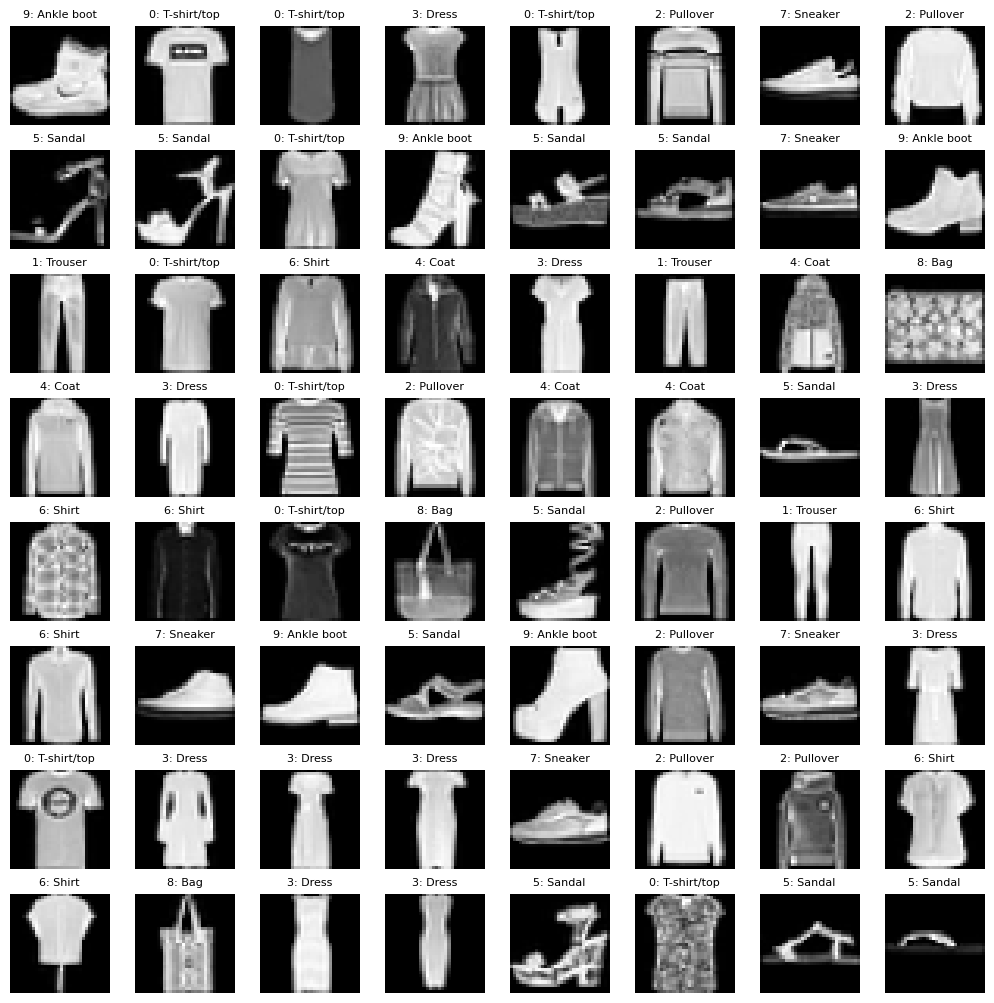

In [4]:
temp_imgs, temp_targets = next(iter(train_dataloader))
# temp_targets = torch.tensor(list(temp_targets))
print(temp_imgs.shape, temp_targets.shape)
plot_image_grid(temp_imgs, temp_targets, ncols=8)

In [11]:
UNET_model = diffusers.UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [17]:
sample_image = temp_imgs[0].unsqueeze(0).to(device)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 32, 32])


In [18]:
print('Output shape:', UNET_model(sample_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 1, 32, 32])


In [19]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt')

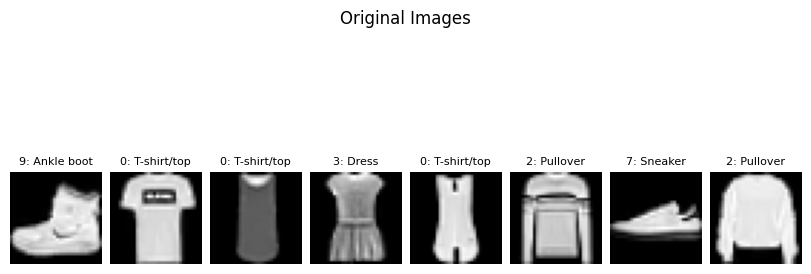

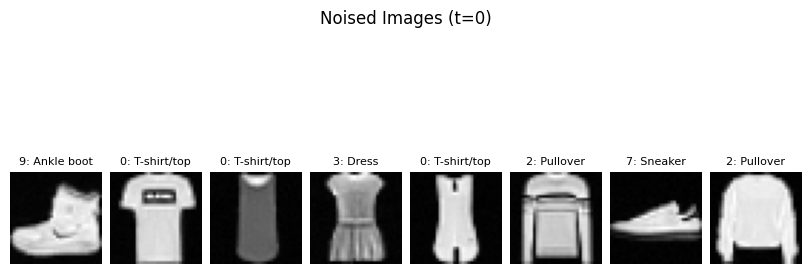

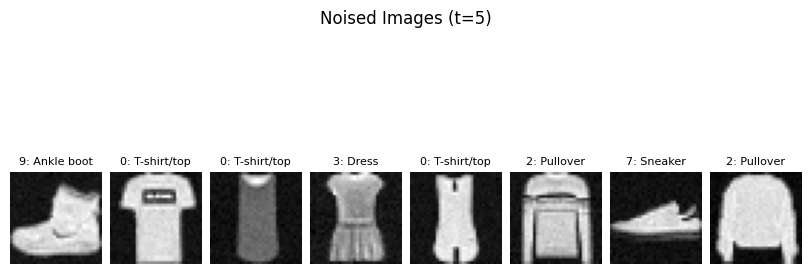

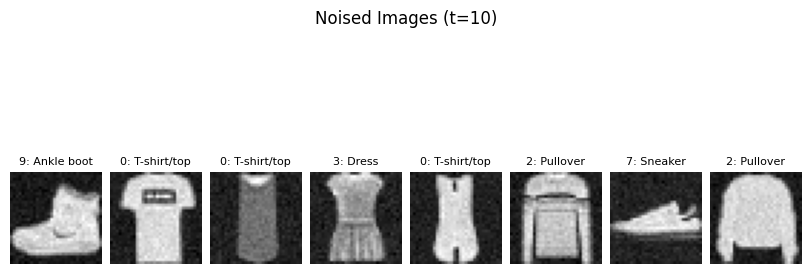

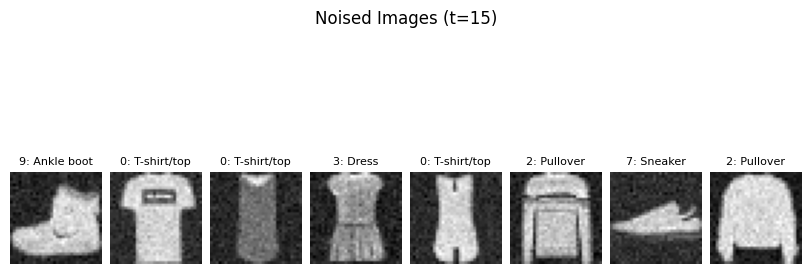

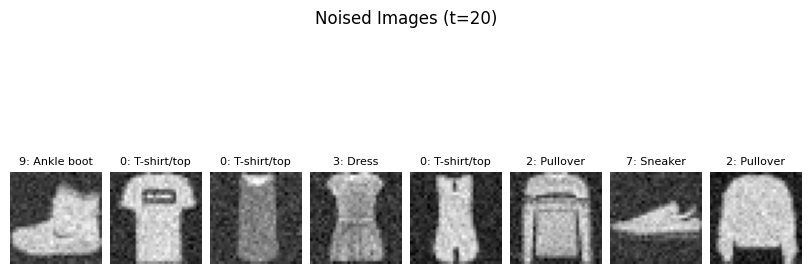

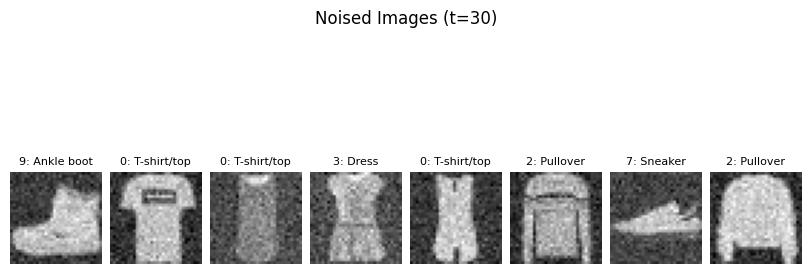

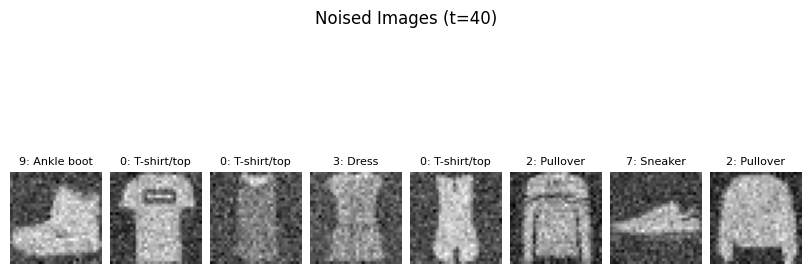

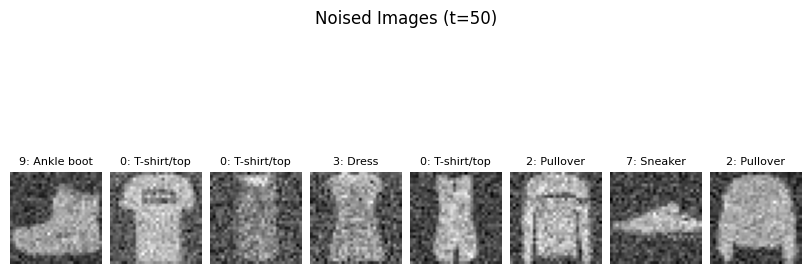

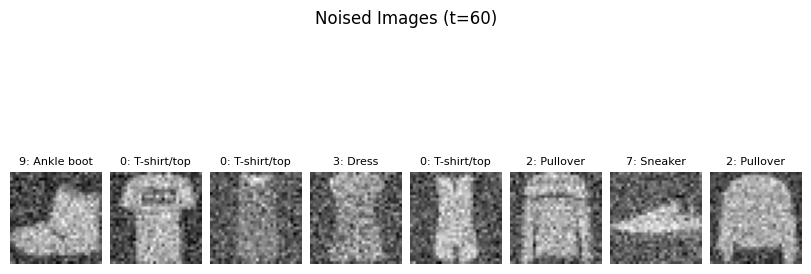

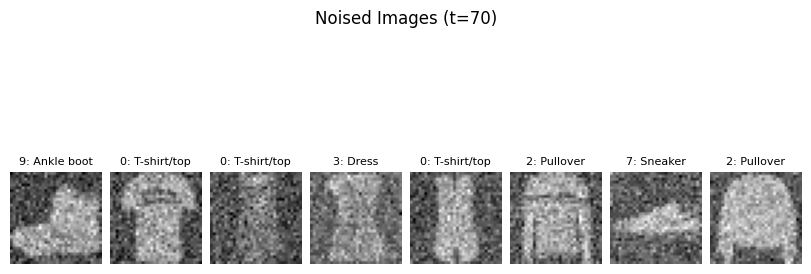

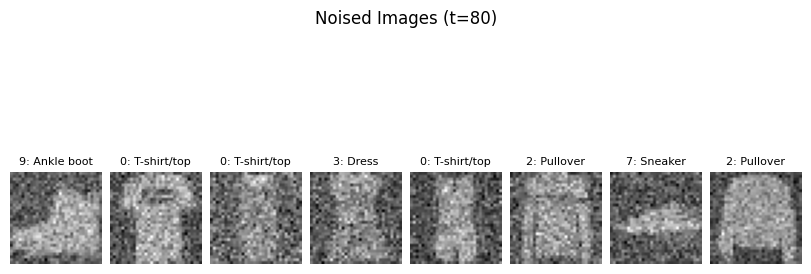

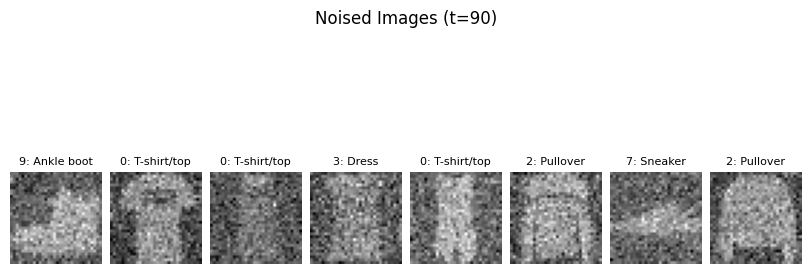

In [20]:
BATCH_SIZE = 8
dl_train = torch.utils.data.DataLoader(train_df, batch_size=BATCH_SIZE)
temp_imgs, temp_targets = next(iter(dl_train))

plot_image_grid(temp_imgs, temp_targets, ncols=8, title="Original Images", figsize=(8,4))

# Plot images at certain 't' noise levels.
x_t = temp_imgs
for t in [0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90]:
    t_vec = torch.tensor([t] * BATCH_SIZE, dtype=torch.long, device="cpu")
    noise = torch.randn_like(temp_imgs)  # Generate noise
    x_t_noisy = noise_scheduler.add_noise(temp_imgs, noise, t_vec)
    
    plot_image_grid(x_t_noisy, temp_targets, ncols=8, title=f"Noised Images (t={t})", figsize=(8,4))


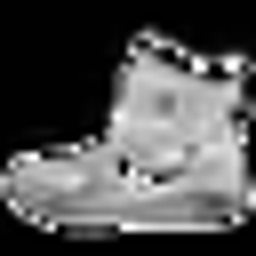

In [21]:
torchvision.transforms.ToPILImage()(sample_image.squeeze(1)).resize((256,256))

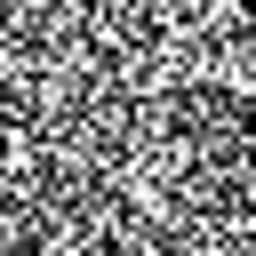

In [23]:
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([199])
noisy_image = noise_scheduler.add_noise(sample_image,noise,timesteps)

torchvision.transforms.ToPILImage()(noisy_image.squeeze(1)).resize((256,256))

### Optimizer

In [24]:
optimizer = torch.optim.AdamW(UNET_model.parameters(),lr=config.learning_rate)

### Learning Rate Scheduler

In [25]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

### Training the Model

In [44]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images, labels = batch
            batch_size = clean_images.shape[0]

            noise = torch.randn(clean_images.shape).to(device)
            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=device)
            
            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps.cpu())
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images,timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred,noise)
                accelerator.backward(loss)
                
                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)
    
    accelerator.unwrap_model(model)

In [45]:
args = (config, UNET_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [46]:
@torch.no_grad()
def sample(unet, scheduler,seed,save_process_dir=None):
    torch.manual_seed(seed)
    
    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)
    
    scheduler.set_timesteps(1000)
    image=torch.randn((1,1,32,32)).to(device)
    num_steps=max(noise_scheduler.timesteps).numpy()
    
    for t in noise_scheduler.timesteps:
        model_output=unet(image,t)['sample']
        image=scheduler.step(model_output,int(t),image,generator=None)['prev_sample']
        if save_process_dir:
            save_image=torchvision.transforms.ToPILImage()(image.squeeze(0))
            save_image.resize((256,256)).save(
                os.path.join(save_process_dir,"seed-"+str(seed)+"_"+f"{num_steps-t.numpy():03d}"+".png"),format="png")
        
    return torchvision.transforms.ToPILImage()(image.squeeze(0))

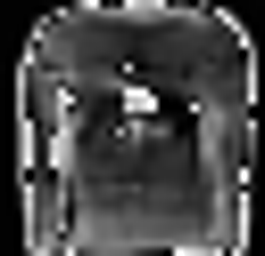

In [47]:
test_image=sample(UNET_model,noise_scheduler,2)
test_image.resize((265,256))

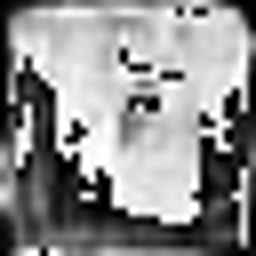

In [49]:
test_image=sample(UNET_model,noise_scheduler,5)
test_image.resize((256,256))

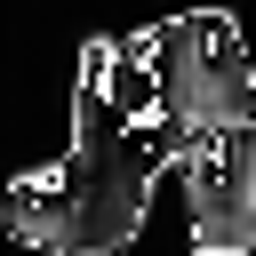

In [50]:
test_image=sample(UNET_model,noise_scheduler,1991)
test_image.resize((256,256))